# Testing implementation and accuracy of solving SRG flow equations

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ March 1, 2023

The goal of this notebook is to test our implementation of the SRG. We explore different ODE solvers, error tolerances, and different implementations (e.g., solving directly for $U(s)$, or solving with respect to $\lambda$ instead of $s$.)<br>

_Last update:_ May 23, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.integrate import ode
from scipy.interpolate import RectBivariateSpline
import time

In [2]:
# Imports from scripts
from scripts.figures import interpolate_matrix, label_lambda, set_rc_parameters
from scripts.integration import unattach_weights_from_matrix
from scripts.potentials import Potential
from scripts.tools import build_coupled_channel_matrix, convert_number_to_string

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Set-up

In [4]:
def rms_error_eigenvalues(H_initial, H_evolved):
    """Calculate the root-mean-square error of the evolved and initial
    eigenvalues.
    """

    eigenvalues_initial, _ = la.eigh(H_initial)
    eigenvalues_evolved, _ = la.eigh(H_evolved)
    
    N = len(eigenvalues_initial)
    
    return np.sqrt(np.sum((eigenvalues_evolved - eigenvalues_initial) ** 2) / N)

In [5]:
def plot_contour(
        k_array, matrix_no_weights, levels_number=61,
        colorbar_limits=(-1.0,1.0), color_map='turbo', axes_limits=(0.0,10.0),
        xlabel_size=16, ylabel_size=16, label=None,
        label_location='upper right', label_size=16
):
    """Plot a contour of the input matrix with respect to k and k'."""
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)

    # --- Plot --- #
    c = ax.contourf(k_array, k_array, matrix_no_weights, levels, cmap=color_map,
                    extend='both')

    # --- Axes limits --- #
    ax.set_xlim(axes_limits)
    ax.set_ylim(axes_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    # Invert y-axis
    ax.invert_yaxis()
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks, format='%.2e')
    
    # --- Label contour plot --- #
    if label is not None:
        ax.add_artist(
            AnchoredText(label, loc=label_location, prop=dict(size=label_size))
        )

In [6]:
def plot_potential_slices(
        k_array, V_matrix, channel, generator='Wegner', lamb=None,
        x_limits=(0.0,15.0), y_limits=(-4.0,2.0), xlabel_size=16, ylabel_size=16
):
    """Plot diagonal and far off-diagonal slices of the potential V(k,k')."""

    # --- Figure set-up --- #
    plt.close('all')
    row_number = 1
    col_number = 2
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(8, 4))
        
    # --- Plot --- #
    
    # \lambda label
    if lamb is not None:
        lambda_label = label_lambda(lamb, generator)
    else:
        lambda_label = label_lambda(np.inf, generator)
         
    # Plot diagonal matrix elements on left column
    axs[0].plot(k_array, np.diag(V_matrix), label=lambda_label, linewidth=2.0)
        
    # Plot off-diagonal matrix elements on right column
    axs[1].plot(k_array, V_matrix[:, 0], label=lambda_label, linewidth=2.0)

    # --- Axes limits --- #
    axs[0].set_xlim(x_limits)
    axs[0].set_ylim(y_limits)
    axs[1].set_xlim(x_limits)
    axs[1].set_ylim(y_limits)
                    
    # --- Axes labels --- #
    # Label x-axis on bottom row
    axs[0].set_xlabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    axs[1].set_xlabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
                    
    # Label y-axis on left column
    axs[0].set_ylabel(r"$V(k,k)$ [fm]", fontsize=ylabel_size)
    axs[1].set_ylabel(rf"$V(k,{k_array[0]:.5f})$ [fm]", fontsize=ylabel_size)

    # --- Adjust axes --- #                      
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.18)

    # --- Legends --- #
    # Label \lambda
    axs[1].legend(fontsize=12, frameon=False)

    # --- Additional labels --- #
    # Label partial wave channel in last sub-plot
    axs[0].set_title(channel)
    axs[1].set_title(channel)

In [7]:
def plot_delta_U_slice(
        k_array, delta_U_matrix, channel, generator, lamb, x_limits=(0.0,15.0),
        y_limits=(-0.5,0.5), xlabel_size=16, ylabel_size=16
):
    """Plot far off-diagonal slices of \delta U(k,k')."""

    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
        
    # --- Plot --- #
    
    # \lambda label
    lambda_label = label_lambda(lamb, generator)
         
    # Plot off-diagonal matrix elements
    ax.plot(k_array[2:], delta_U_matrix[2:,0], label=lambda_label,
            linewidth=2.0)

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
                    
    # --- Axes labels --- #
    # Label x-axis on bottom row
    ax.set_xlabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
                    
    # Label y-axis on left column
    ax.set_ylabel(rf"$\delta U(k,{k_array[0]:.5f})$ [fm$^3$]",
                  fontsize=ylabel_size)

    # --- Legends --- #
    # Label \lambda
    ax.legend(fontsize=12, frameon=False)

    # --- Additional labels --- #
    # Label partial wave channel
    ax.set_title(channel)

## Check initial potential

In [8]:
kvnn, channel, kmax, kmid, ntot = 6, '3S1', 30.0, 4.0, 120
# kvnn, channel, kmax, kmid, ntot = 111, '3S1', 10.0, 2.0, 120

# Call Potential
potential = Potential(kvnn, channel, kmax, kmid, ntot)

# Get momenta, weights, and initial potential
k_array, k_weights = potential.load_mesh()
V_initial = potential.load_potential(method='initial')

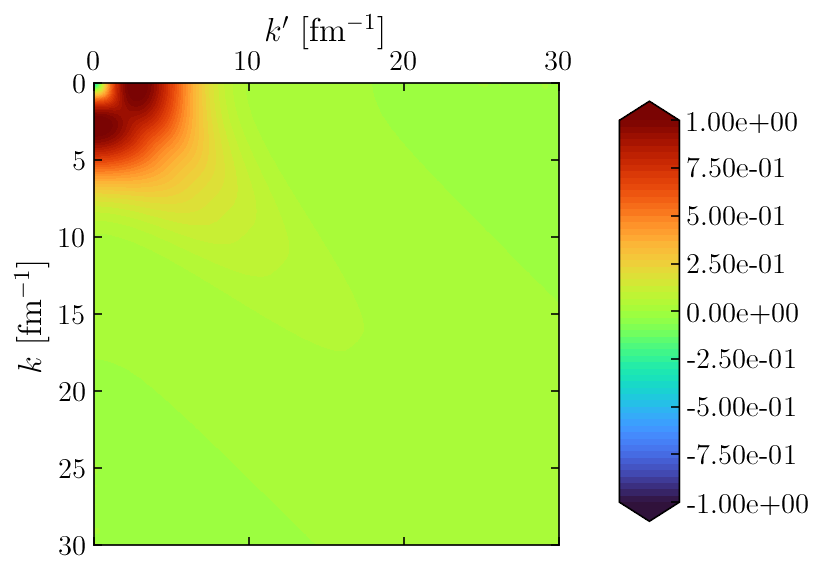

In [9]:
# V(k, k') in 3S1-3S1 channel
plot_contour(k_array, V_initial[:ntot,:ntot], axes_limits=(0.0,kmax))

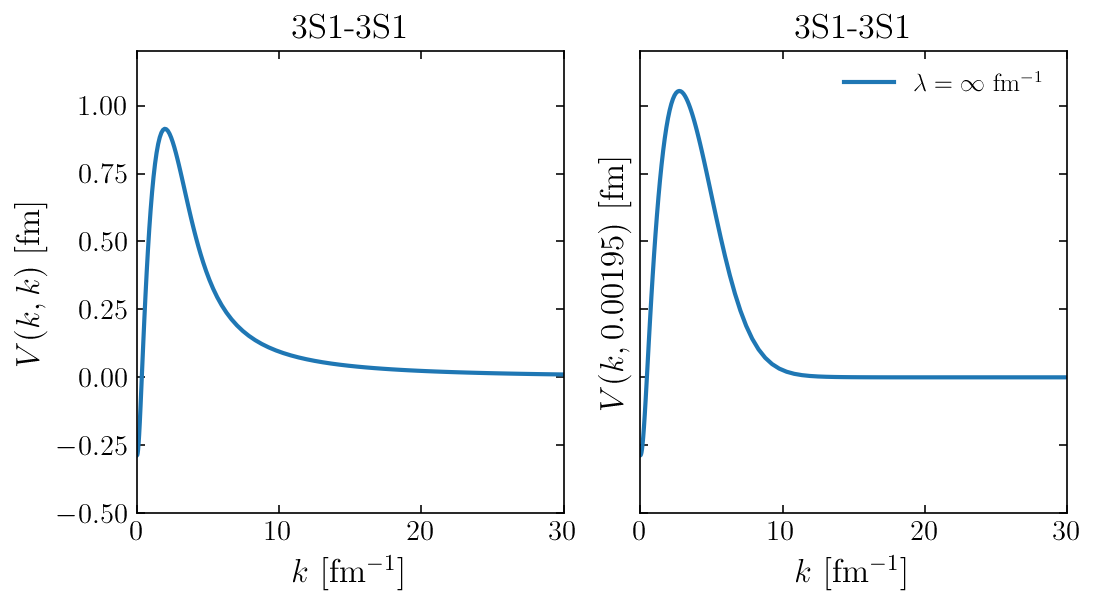

In [10]:
y_limits = (-0.5, 1.2)  # AV18
# y_limits = (-1.8, 0.3)  # SMS N4LO 450 MeV

# V(k,k) and V(k,k'=k_0)
plot_potential_slices(k_array, V_initial[:ntot,:ntot], '3S1-3S1',
                      x_limits=(0.0,kmax), y_limits=y_limits)

## SRG class

In [11]:
class SRG:
    """
    Evolves potentials to band-diagonal or block-diagonal decoupled form with
    respect to the flow parameter \lambda [fm^-1], and possibly \Lambda_BD.

    Parameters
    ----------
    potential : Potential
        NN potential projected onto a partial wave channel in relative momentum
        space.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
            
    """

    
    def __init__(self, potential, generator):
        """Loads the initial Hamiltonian and other relevant operators depending
        on the potential and the SRG generator.
        """
        
        # Set potential as instance attribute
        self.potential = potential
        
        # Get initial Hamiltonian associated with the potential
        H_initial_MeV = potential.load_hamiltonian()  # [MeV]

        # Convert Hamiltonian to scattering units [fm^-2]
        self.H_initial = H_initial_MeV / Potential.hbar_sq_over_m

        # Set length of Hamiltonian
        self.Ntot = len(self.H_initial)

        # Set relative kinetic energy as instance attribute
        T_rel_MeV = potential.load_kinetic_energy()  # [MeV]
        self.T_rel = T_rel_MeV / Potential.hbar_sq_over_m  # [fm^-2]

        # Need relative momenta for construction of projection operators for
        # the block-diagonal generator
        if generator == 'Block-diag':

            # Get momentum array (don't worry about weights) in [fm^-1]
            self.k_array, _ = potential.load_mesh()
            self.ntot = len(self.k_array)

        # Set generator for evaluation of \eta
        self.generator = generator
        
        
    def __call__(
            self, lambda_array, lambda_bd_array=None, lambda_initial=20.0,
            method='hamiltonian', save=False):
        """
        Evolve the Hamiltonian at each value of \lambda, and possibly
        \Lambda_BD for block-diagonal decoupling.
        
        Parameters
        ----------
        lambda_array : 1-D ndarray
            SRG evolution parameters \lambda [fm^-1].
        lambda_bd_array : 1-D ndarray, optional
            \Lambda_BD values for block-diagonal generator [fm^-1].
        lambda_initial : float, optional
            Initial value of lambda [fm^-1]. Technically this should be
            infinity but a large value (~20 fm^-1) is sufficient.
        save : bool, optional
            If true, saves data files.
        method : str, optional
            The default method is to solve the flow equation
                dH(s)/ds = [\eta(s), H(s)],
            specified by method='hamiltonian'. Alternatively, one can set
            method='srg_transformation' to solve for U(s) directly:
                dU(s)/ds = \eta(s) U(s).
            
        Returns
        -------
        d : dict
            Dictionary storing each evolved Hamiltonian (or SRG transformation)
            with keys (floats) corresponding to each \lambda value (and
            possibly an additional key for \Lambda_BD). E.g., d[1.5] returns
            the evolved Hamiltonian at \lambda = 1.5 fm^-1.
            
        """

        # Initial Hamiltonian as a vector
        if method == 'hamiltonian':
            
            H_initial_vector = self.matrix_to_vector(self.H_initial)
            
        # Initial SRG transformation as a matrix
        elif method == 'srg_transformation':
            
            U_initial = np.eye(self.Ntot)

            # Initial SRG transformation as a vector
            U_initial_vector  = np.reshape(U_initial, -1)

        # Start time
        t0 = time.time()

        # Evolve the Hamiltonian (or U) to each value of \lambda and store in
        # a dictionary (loop over \Lambda_BD as well for block-diagonal)
        d = {}
        
        # Set-up ODE solver
        solver = self.get_ode_solver(lambda_initial, method)
        
        # Block-diagonal generator
        if self.generator == 'Block-diag':
            
            for lambda_bd in lambda_bd_array:

                # Set the projection operators P and Q
                self.set_projection_operators(lambda_bd)

                # Set first key as \Lambda_BD
                d[lambda_bd] = {}

                for lamb in lambda_array:

                    # Solve ODE up to lamb and store in dictionary
                    while solver.successful() and round(solver.t, 2) > lamb:
                    
                        # Get ODE solver step-size in \lambda
                        dlamb = self.select_step_size(solver.t, lamb)

                        # Integrate to next step in lambda
                        solution_vector = solver.integrate(solver.t - dlamb)

                    # Store evolved Hamiltonian (or U) matrix in dictionary
                    if method == 'hamiltonian':
                    
                        d[lambda_bd][lamb] = self.vector_to_matrix(
                            solution_vector)
                    
                        if save:  # Save evolved potential?
                    
                            V_evolved = d[lambda_bd][lamb] - self.T_rel  # fm^-2
                            self.potential.save_potential(
                                V_evolved, 'srg', self.generator, lamb,
                                lambda_bd
                            )
                    
                    elif method == 'srg_transformation':
                    
                        d[lambda_bd][lamb] =  np.reshape(solution_vector,
                                                         (self.Ntot, self.Ntot))
                    
                        if save:  # Save SRG transformation?

                            save_srg_transformation(
                                d[lambda_bd][lamb], self.potential,
                                self.generator, lamb, lambda_bd
                            )
     
        # Band-diagonal generators
        else:
            
            # Set-up ODE solver
            solver = self.get_ode_solver(lambda_initial, method)

            for lamb in lambda_array:

                # Solve ODE up to lamb and store in dictionary
                while solver.successful() and round(solver.t, 2) > lamb:
                    
                    # Get ODE solver step-size in \lambda
                    dlamb = self.select_step_size(solver.t, lamb)

                    # Integrate to next step in lambda
                    solution_vector = solver.integrate(solver.t - dlamb)

                # Store evolved Hamiltonian (or U) matrix in dictionary
                if method == 'hamiltonian':
                    
                    d[lamb] = self.vector_to_matrix(solution_vector)
                    
                    if save:  # Save evolved potential?
                    
                        V_evolved = d[lamb] - self.T_rel  # fm^-2
                        self.potential.save_potential(V_evolved, 'srg',
                                                      self.generator, lamb)
                    
                elif method == 'srg_transformation':
                    
                    d[lamb] =  np.reshape(solution_vector,
                                          (self.Ntot, self.Ntot))
                    
                    if save:  # Save SRG transformation?
                    
                        save_srg_transformation(d[lamb], self.potential,
                                                self.generator, lamb)

        # End time
        t1 = time.time()

        # Print details
        mins = round((t1 - t0) / 60.0, 4)  # Minutes elapsed evolving H(s)
        print("_" * 85)
        lamb_str = convert_number_to_string(lambda_array[-1])
        print(f"Done evolving to final \lambda = {lamb_str} fm^-1 after"
              f" {mins:.4f} minutes.")
        print("_" * 85)
        print("\nSpecifications:\n")
        print(f"kvnn = {self.potential.kvnn:d}")
        print(f"channel = {self.potential.channel}")
        print(
            f"kmax = {self.potential.kmax:.1f}, "
            f"kmid = {self.potential.kmid:.1f}, "
            f"ntot = {self.potential.ntot:d}"
        )
        print(f"method = SRG, generator = {self.generator}")
        if self.generator == 'Block-diag':
            lambda_bd_str = convert_number_to_string(lambda_bd_array[-1])
            print(f"Final \Lambda_BD = {lambda_bd_str} fm^-1")

        return d

    
    def set_projection_operators(self, lambda_bd):
        """
        Sets sub-block projection operators for block-diagonal generator where
        P_matrix (Q_matrix) corresponds to the low (high) sub-block of the
        Hamiltonian.

        Parameters
        ----------
        lambda_bd : float
            SRG \Lambda_BD value for block-diagonal generator [fm^-1].

        """

        # Use booleans to partition the Hamiltonian
        bool_array = self.k_array < lambda_bd

        # Matrix of ones along the diagonal up to k > lambda_bd
        P_matrix = np.diag(np.ones(self.ntot) * bool_array)

        # Opposite of P
        Q_matrix = np.identity(self.ntot) - P_matrix

        # Projection operators for coupled-channel potentials
        if self.ntot != self.Ntot:
            zeros = np.zeros((self.ntot, self.ntot))
            P_matrix = build_coupled_channel_matrix(P_matrix, zeros, zeros,
                                                    P_matrix)
            Q_matrix = build_coupled_channel_matrix(Q_matrix, zeros, zeros,
                                                    Q_matrix)

        # Save both operators for evaluations of \eta
        self.P_matrix = P_matrix
        self.Q_matrix = Q_matrix

        
    def matrix_to_vector(self, M):
        """
        Takes the upper triangle of the matrix M (including the diagonal) 
        and reshapes it into a vector v.
        
        Parameters
        ----------
        M : 2-D ndarray
            Input matrix of shape (N, N).
            
        Returns
        -------
        v : 1-D ndarray
            Output vector of shape (N*(N+1)/2,).
            
        """

        # Length of matrix
        N = len(M)
        # Length of vectorized matrix
        n = int(N * (N + 1) / 2)

        # Initialize vectorized matrix
        v = np.zeros(n)

        # Algorithm for reshaping M to the vector v
        i = 0
        j = N
        for k in range(N):
            v[i:j] = M[k][k:]
            i = j
            j += N - k - 1

        return v

    
    def vector_to_matrix(self, v):
        """
        Takes the vector of an upper triangle matrix v and returns the full
        matrix M. Use only for symmetric matrices.
        
        Parameters
        ----------
        v : 1-D ndarray
            Input vector of shape (N*(N+1)/2,).
        
        Returns
        -------
        A : 2-D ndarray
            Output matrix of shape (N, N).
            
        """

        # Length of matrix (we know the length from the Hamiltonian)
        N = self.Ntot

        # Initialize matrix
        M = np.zeros((N, N))

        # Build the upper half of M with the diagonal included

        # Algorithm for reshaping v to the matrix M
        i = 0
        j = N
        for k in range(N):
            M[k, k:] = v[i:j]
            i = j
            j += N - k - 1

        # Now reflect the upper half to lower half to build full matrix
        # M.T - np.diag(np.diag(M)) is the lower half of M excluding diagonal
        return M + (M.T - np.diag(np.diag(M)))

    
    def commutator(self, A, B):
        """Commutator of square matrices A and B."""

        return A @ B - B @ A

    
    def eta(self, H_matrix):
        """
        SRG generator \eta = [G, H] where G is specified by the decoupling
        scheme.
        
        Parameters
        ----------
        H_matrix : 2-D ndarray
            Evolving Hamiltonian in matrix form [fm^-2].
        
        Returns
        -------
        output : 2-D ndarray
            SRG generator \eta in matrix form [fm^-4].
        
        """

        # G = H_D (diagonal of the evolving Hamiltonian)
        if self.generator == 'Wegner':

            G_matrix = np.diag(np.diag(H_matrix))

        # G = T_rel (relative kinetic energy)
        elif self.generator == 'T':

            G_matrix = self.T_rel

        # G = H_BD (block-diagonal of the evolving Hamiltonian)
        elif self.generator == 'Block-diag':

            G_matrix = (self.P_matrix @ H_matrix @ self.P_matrix
                        + self.Q_matrix @ H_matrix @ self.Q_matrix)

        # \eta = [G, H]
        return self.commutator(G_matrix, H_matrix)

    
    def H_deriv(self, lamb, H_vector):
        """
        Right-hand side of the SRG flow equation.
        
        Parameters
        ----------
        lamb : float
            SRG evolution parameter \lambda [fm^-1].
        H_vector : 1-D ndarray
            Evolving Hamiltonian [fm^-2].
        
        Returns
        -------
        dH_vector : 1-D ndarray
            Derivative with respect to \lambda of the evolving Hamiltonian
            which is also a vector [fm^-1].

        """

        # Matrix form of the evolving Hamiltonian
        H_matrix = self.vector_to_matrix(H_vector)

        # Get SRG generator \eta = [G, H]
        eta_matrix = self.eta(H_matrix)

        # RHS of the flow equation in matrix form
        dH_matrix = -4.0 / lamb ** 5 * self.commutator(eta_matrix, H_matrix)

        # Returns vector form of RHS of flow equation
        dH_vector = self.matrix_to_vector(dH_matrix)

        return dH_vector

    
    def U_deriv(self, lamb, U_vector):
        """
        Right-hand side of differential equation for U(\lambda)
            dU(\lambda)/d\lambda = -4/\lambda^5 \eta(\lambda) U(\lambda).
        
        Parameters
        ----------
        lamb : float
            SRG evolution parameter \lambda [fm^-1].
        U_vector : 1-D ndarray
            SRG transformation [unitless] as a function of \lambda.
        
        Returns
        -------
        dU_vector : 1-D ndarray
            Derivative with respect to \lambda of the SRG transformation which
            is also a vector [fm].

        """

        # Matrix form of the SRG transformation
        U_matrix = np.reshape(U_vector, (self.Ntot, self.Ntot))

        # Evolve the Hamiltonian to compute \eta
        H_matrix = U_matrix @ self.H_initial @ U_matrix.T

        # Get SRG generator \eta = [G, H]
        eta_matrix = self.eta(H_matrix)

        # RHS in matrix form
        dU_matrix = -4.0 / lamb ** 5 * eta_matrix @ U_matrix

        # Returns vector form of RHS
        dU_vector = np.reshape(dU_matrix, -1)

        return dU_vector

    
    def select_step_size(self, solver_lambda, lambda_final):
        """
        Select ODE solver step-size depending on the extent of evolution.
        We can take bigger steps at large values of \lambda.

        Parameters
        ----------
        solver_lambda : float
            The ODE solver's interal value of \lambda [fm^-1].
        lambda_final : float
            The external value of \lambda [fm^-1].

        Returns
        -------
        dlamb : float
            Step-size in terms of \lambda [fm^-1].

        """
            
        if solver_lambda >= 6.0:
            dlamb = 1.0
        elif 2.5 <= solver_lambda < 6.0:
            dlamb = 0.5
        elif 1.5 <= solver_lambda < 2.5:
            dlamb = 0.1
        else:
            dlamb = 0.05

        return dlamb

    
    def get_ode_solver(self, lambda_initial, method='hamiltonian'):
        """Sets up the ODE solver with SciPy's integrate.ode function."""

        # Solving for H(s)
        if method == 'hamiltonian':

            solver = ode(self.H_deriv)

            # Initial Hamiltonian as a vector
            H_initial = self.matrix_to_vector(self.H_initial)

            # Set initial conditions
            solver.set_initial_value(H_initial, lambda_initial)

        # Solving for U(s)
        elif method == 'srg_transformation':

            solver = ode(self.U_deriv)

            # Set initial value: U = identity matrix and make vector
            U_initial = np.eye(self.Ntot).reshape(-1)
            solver.set_initial_value(U_initial, lambda_initial)

        # Print an error message if method is invalid
        else:

            raise RuntimeError("Need to specify a valid method.")

        # Following the example in Hergert:2016iju with modifications to
        # nsteps and error tolerances
        solver.set_integrator('vode', method='bdf', order=5, atol=1e-10,
                              rtol=1e-10, nsteps=5000000)

        return solver

In [12]:
def srg_transformation_file_name(potential, generator, lamb, lambda_bd=None):
    """Get file name for SRG transformation."""
        
    file_name = (f"u_{potential.channel}_kvnn_{potential.kvnn_string}"
                 f"_{generator}")

    # Get \lambda with correct number of decimals
    if lamb == round(lamb, 1):
        lamb_str = str(round(lamb, 1))
    else:
        lamb_str = str(round(lamb, 2))

    # Add \Lambda_BD to name for block-diagonal generator
    if generator == 'Block-diag':
        file_name += f'{lambda_bd:.2f}_lambda{lamb_str}'
    else:
        file_name += f'_lambda{lamb_str}'

    file_name += '.out'
        
    return file_name

In [13]:
def save_srg_transformation(
        U_matrix, potential, generator, lamb, lambda_bd=None
):
    """Saves the SRG transformation."""
        
    # Get file name for the SRG transformation matrix elements
    file_name = srg_transformation_file_name(potential, generator, lamb,
                                             lambda_bd)

    # Get momenta and weights
    k_array, k_weights = potential.load_mesh()

    f = open(potential.potential_directory + file_name, 'w')

    # Write each sub-block as a column for coupled-channel transformations
    if potential.coupled_channel_bool:

        header = '{:^15s}{:^15s}{:^23s}{:^23s}{:^23s}{:^23s}'.format(
            'k', 'kp', 'U11', 'U12', 'U21', 'U22'
        )
        f.write('#' + header + '\n')

        for i, ik in enumerate(k_array):
            for j, jk in enumerate(k_array):

                u11 = U_matrix[i, j]
                u12 = U_matrix[i, j+potential.ntot]
                u21 = U_matrix[i+potential.ntot, j]
                u22 = U_matrix[i+potential.ntot, j+potential.ntot]

                line = ('{:^15.6f}{:^15.6f}'.format(ik, jk)
                        + '{:^23e}{:^23e}'.format(u11, u12)
                        + '{:^23e}{:^23e}'.format(u21, u22))

                f.write(line + '\n')

    else:

        header = '{:^15s}{:^15s}{:^23s}'.format('k', 'kp', 'U')
        f.write('#' + header + '\n')

        for i, ik in enumerate(k_array):
            for j, jk in enumerate(k_array):

                u = U_matrix[i, j]

                line = '{:^15.6f}{:^15.6f}{:^23e}'.format(ik, jk, u)

                f.write(line + '\n')

    f.close()

In [14]:
def load_srg_transformation(potential, generator, lamb, lambda_bd=None):
    """
    Loads SRG unitary transformation from data file generated from solving
        dU/d\lambda =  -4/\lambda^5 \eta(\lambda) U(\lambda).
        
    Parameters
    ----------
    potential : Potential
        NN potential projected onto a partial wave channel in relative momentum
        space.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        SRG evolution parameter \lambda [fm^-1].
    lambda_bd : float, optional
        SRG \Lambda_BD value for block-diagonal generator [fm^-1].
            
    Returns
    -------
    U_matrix : 2-D ndarray
        SRG unitary transformation matrix with integration weights [unitless].
            
    """

    # Get file name for the SRG transformation matrix elements
    file_name = srg_transformation_file_name(potential, generator, lamb,
                                             lambda_bd)

    # Load output file
    data = np.loadtxt(potential.potential_directory + file_name)

    # Coupled-channel potential?
    if potential.coupled_channel_bool:

        u11 = np.reshape(data[:, 2], (potential.ntot, potential.ntot))
        u12 = np.reshape(data[:, 3], (potential.ntot, potential.ntot))
        u21 = np.reshape(data[:, 4], (potential.ntot, potential.ntot))
        u22 = np.reshape(data[:, 5], (potential.ntot, potential.ntot))
        U_matrix = build_coupled_channel_matrix(u11, u12, u21, u22)

    else:

        U_matrix = np.reshape(data[:, 2], (potential.ntot, potential.ntot))

    return U_matrix

In [15]:
def compute_srg_transformation(H_initial, H_evolved):
    """
    SRG unitary transformation built out of eigenvectors of the initial and 
    evolved Hamiltonians.
    
    Parameters
    ----------
    H_initial : 2-D ndarray
        Initial Hamiltonian matrix [MeV].
    H_evolved : 2-D ndarray
        Evolved Hamiltonian matrix [MeV].
        
    Returns
    -------
    U_matrix : 2-D ndarray
        SRG unitary transformation matrix with integration weights [unitless].
        
    """

    Ntot = len(H_initial)

    # Get the eigenvectors of the initial and SRG-evolved Hamiltonians
    _, vecs_initial = la.eigh(H_initial)
    _, vecs_evolved = la.eigh(H_evolved)

    # Initialize unitary transformation U with same size as Hamiltonians
    U_matrix = np.zeros((Ntot, Ntot))

    # Transformation is given by summing over the outer product of evolved and
    # initial eigenvectors
    for alpha in range(Ntot):

        # Individual eigenvectors (these are already sorted correctly from 
        # numpy.linalg.eigh)
        psi_alpha_initial = vecs_initial[:, alpha]
        psi_alpha_evolved = vecs_evolved[:, alpha]

        # Make sure the phases match
        if psi_alpha_initial.T @ psi_alpha_evolved < 0:
            psi_alpha_evolved = -psi_alpha_evolved

        # Outer product of eigenvectors
        U_matrix += np.outer(psi_alpha_evolved, psi_alpha_initial)

    return U_matrix

## Check evolved potential

In [16]:
lambda_array = np.array([6.0, 4.0, 3.0, 2.5, 2.0, 1.8, 1.6, 1.5, 1.4, 1.35])

### Solving for $H(\lambda)$

In [17]:
# # SRG-evolved potential solving for H(\lambda)
# d1 = SRG(potential, 'Wegner')(lambda_array, method='hamiltonian', save=True)

In [18]:
# RMS error in eigenvalues
H_initial = potential.load_hamiltonian()
H_evolved = potential.load_hamiltonian(method='srg', generator='Wegner',
                                       lamb=lambda_array[-1])
print(f"RMS error = {rms_error_eigenvalues(H_initial, H_evolved):6e}.")

RMS error = 2.613630e-05.


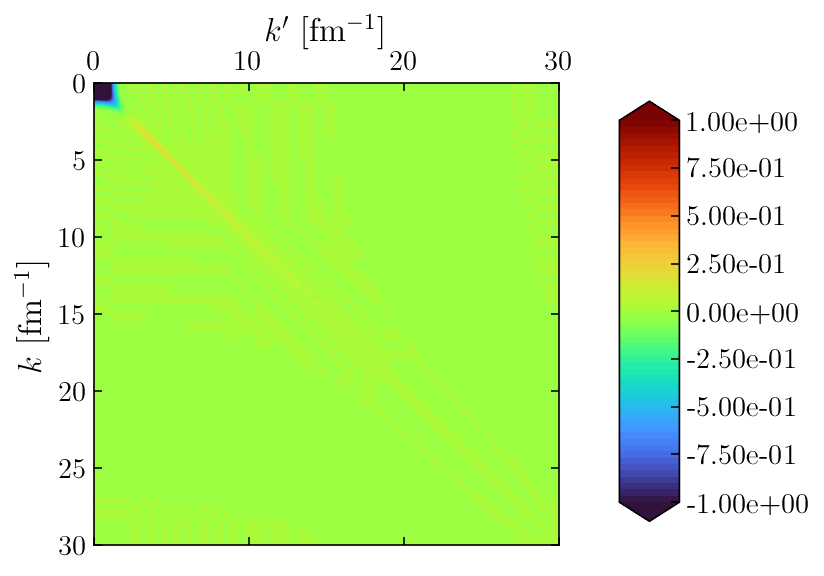

In [19]:
# V(k, k') in 3S1-3S1 channel
V_evolved = potential.load_potential(method='srg', generator='Wegner',
                                     lamb=lambda_array[-1])

plot_contour(k_array, V_evolved[:ntot,:ntot], axes_limits=(0.0,kmax))

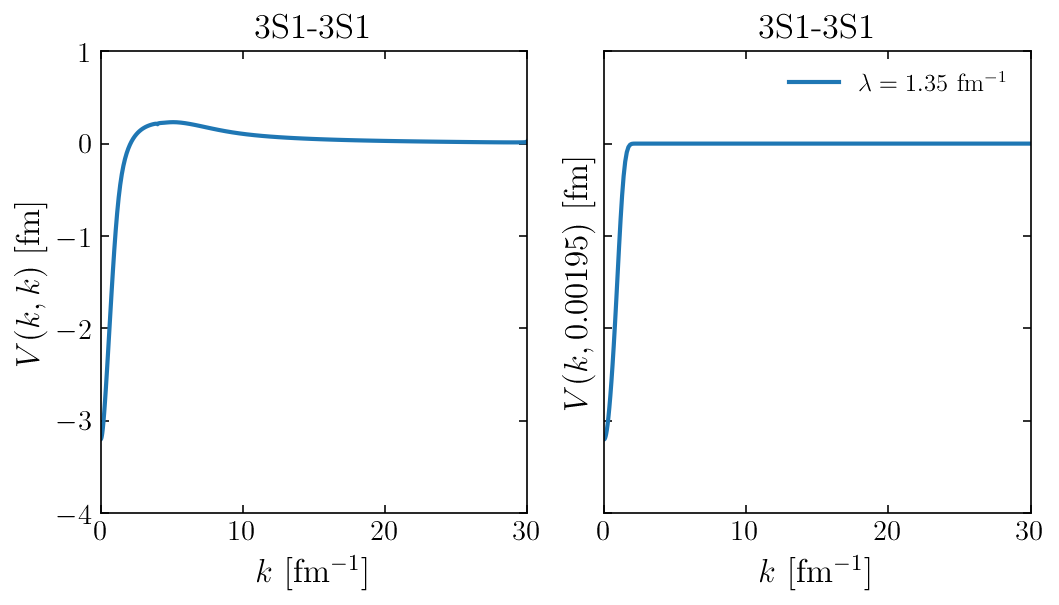

In [20]:
y_limits = (-4, 1.0)  # AV18
# y_limits = (-1.8, 0.3)  # SMS N4LO 450 MeV

# V(k,k) and V(k,k'=k_0)
plot_potential_slices(
    k_array, V_evolved[:ntot,:ntot], '3S1-3S1', lamb=lambda_array[-1],
    x_limits=(0.0,kmax), y_limits=y_limits
)

### Solving for $U(\lambda)$

In [21]:
# # SRG-evolved potential solving for U(\lambda)
# d2 = SRG(potential, 'Wegner')(lambda_array, method='srg_transformation',
#                               save=True)

In [22]:
# RMS error in eigenvalues
U_matrix = load_srg_transformation(potential, 'Wegner', lambda_array[-1])
H_evolved = U_matrix @ H_initial @ U_matrix.T  # MeV
print(f"RMS error = {rms_error_eigenvalues(H_initial, H_evolved):6e}.")

RMS error = 5.269640e-03.


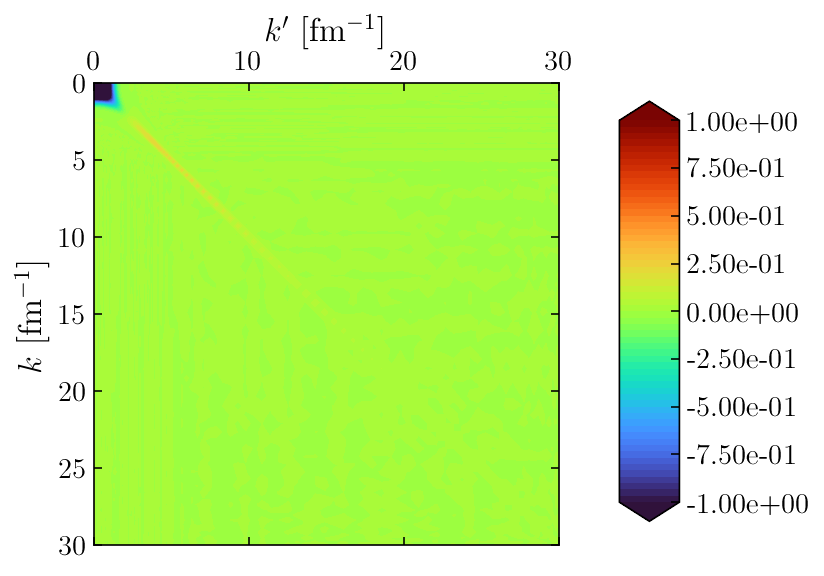

In [23]:
V_evolved_MeV = H_evolved - potential.load_kinetic_energy()  # MeV
V_evolved = unattach_weights_from_matrix(
    k_array, k_weights, V_evolved_MeV / Potential.hbar_sq_over_m,
    coupled_channel=potential.coupled_channel_bool
)  # fm

# V(k, k') in 3S1-3S1 channel
plot_contour(k_array, V_evolved[:ntot,:ntot], axes_limits=(0.0,kmax))

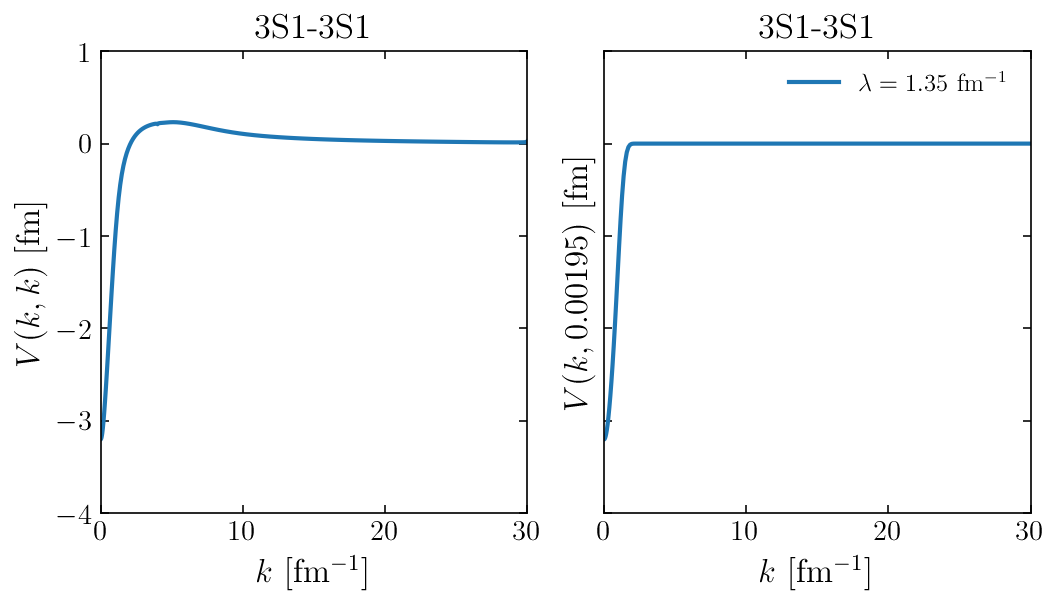

In [24]:
y_limits = (-4, 1.0)  # AV18
# y_limits = (-1.8, 0.3)  # SMS N4LO 450 MeV

# V(k,k) and V(k,k'=k_0)
plot_potential_slices(
    k_array, V_evolved[:ntot,:ntot], '3S1-3S1', lamb=lambda_array[-1],
    x_limits=(0.0,kmax), y_limits=y_limits
)

## Check SRG transformation

In [25]:
def get_delta_U(U_matrix, k_array=None, k_weights=None):
    """Matrix elements of \delta U(k,k') with or without integration factors."""
    
    # Identity matrix [unitless]
    I_matrix = np.eye(len(U_matrix))

    # \delta U matrix [unitless]
    delta_U = U_matrix - I_matrix
    
    # Return \delta U without integration weights [fm^3]
    if k_array is not None and k_weights is not None:
        return unattach_weights_from_matrix(k_array, k_weights, U_matrix)
    # Return \delta U with integration weights [unitless]
    else:
        return delta_U

### SRG transformation using eigenvectors of Hamiltonians

In [26]:
# SRG transformation using eigenvectors of Hamiltonians
H_evolved = potential.load_hamiltonian(method='srg', generator='Wegner',
                                       lamb=lambda_array[-1])
U_matrix_eigenvectors = compute_srg_transformation(H_initial, H_evolved)
# print(np.diag(U_matrix_eigenvectors))

In [27]:
# Get \delta U = U - I
delta_U_weights = get_delta_U(U_matrix_eigenvectors)

In [28]:
# Check that \delta U(k_i, k_j) is exactly zero along the diagonal
print(np.diag(delta_U_weights))

[-2.53048649e-09 -1.61617278e-07 -1.52537612e-06 -7.10827138e-06
 -2.28556394e-05 -5.83327399e-05 -1.26945782e-04 -2.45463536e-04
 -4.32618339e-04 -7.06666118e-04 -1.08199689e-03 -1.56523253e-03
 -2.15166171e-03 -2.82325746e-03 -3.54962979e-03 -4.29285217e-03
 -5.01566771e-03 -5.69024737e-03 -6.30260438e-03 -6.84837225e-03
 -7.32143752e-03 -7.70530366e-03 -7.97870707e-03 -8.13531684e-03
 -8.20139478e-03 -8.23484740e-03 -8.30666169e-03 -8.48005609e-03
 -8.79920392e-03 -9.28759945e-03 -9.95057183e-03 -1.07781944e-02
 -1.17477227e-02 -1.28258494e-02 -1.39710487e-02 -1.51360320e-02
 -1.62702573e-02 -1.73223631e-02 -1.82424132e-02 -1.89839207e-02
 -1.95056076e-02 -1.97730435e-02 -1.97604741e-02 -1.94528328e-02
 -1.88467702e-02 -1.79480780e-02 -1.67650716e-02 -1.53039701e-02
 -1.35723721e-02 -1.15880157e-02 -9.38388603e-03 -7.00594551e-03
 -4.50691173e-03 -1.94376267e-03 -8.65445725e-03 -2.11227320e-02
 -3.53518729e-02 -5.16117211e-02 -7.04036115e-02 -9.30394616e-02
 -1.20124427e-01 -1.50456

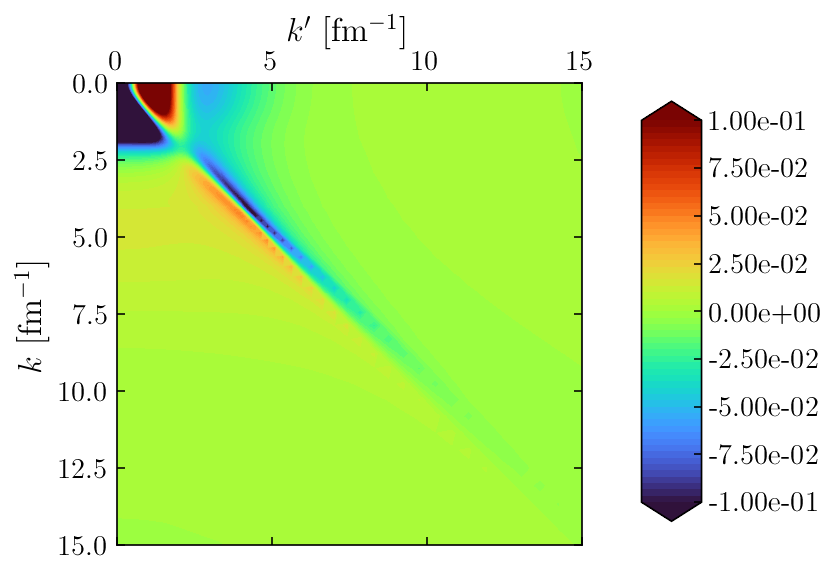

In [29]:
delta_U = unattach_weights_from_matrix(
    k_array, k_weights, delta_U_weights,
    coupled_channel=potential.coupled_channel_bool
)

# \delta U(k, k') in 3S1-3S1 channel
plot_contour(k_array, delta_U[:ntot,:ntot], colorbar_limits=(-0.1,0.1),
             axes_limits=(0.0,15.0))

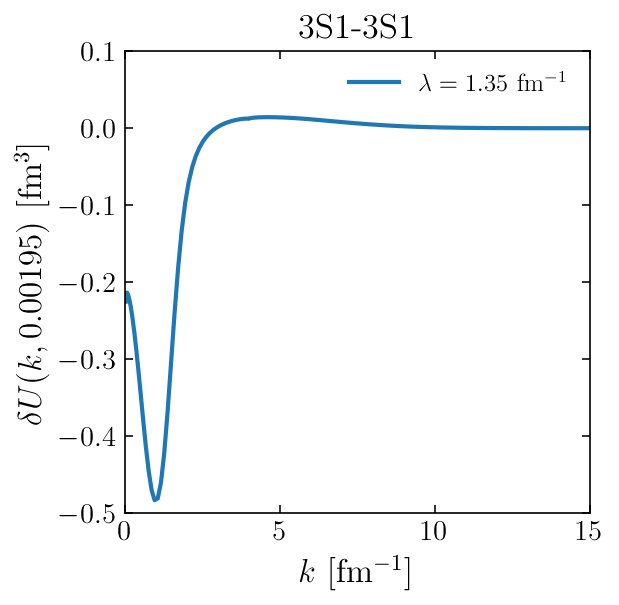

In [30]:
# Off-diagonal slice of \delta U(k, k') in 3S1-3S1 channel
plot_delta_U_slice(k_array, delta_U[:ntot,:ntot], '3S1-3S1', 'Wegner',
                   lambda_array[-1], x_limits=(0.0,15.0), y_limits=(-0.5,0.1))

### SRG transformation via solving directly for $U(\lambda)$

In [31]:
# SRG transformation via solving directly for U(\lambda)
U_matrix_direct = load_srg_transformation(potential, 'Wegner', lambda_array[-1])
# print(np.diag(U_matrix_direct))

In [32]:
# Get \delta U = U - I
delta_U_weights = get_delta_U(U_matrix_direct)

In [33]:
# Check that \delta U(k_i, k_j) is exactly zero along the diagonal
print(np.diag(delta_U_weights))

[ 0.00000000e+00 -2.00000000e-07 -1.50000000e-06 -7.10000000e-06
 -2.29000000e-05 -5.83000000e-05 -1.26900000e-04 -2.45500000e-04
 -4.32600000e-04 -7.06700000e-04 -1.08200000e-03 -1.56520000e-03
 -2.15170000e-03 -2.82330000e-03 -3.54960000e-03 -4.29290000e-03
 -5.01570000e-03 -5.69030000e-03 -6.30260000e-03 -6.84840000e-03
 -7.32150000e-03 -7.70530000e-03 -7.97870000e-03 -8.13530000e-03
 -8.20140000e-03 -8.23490000e-03 -8.30670000e-03 -8.48010000e-03
 -8.79920000e-03 -9.28760000e-03 -9.95060000e-03 -1.07782000e-02
 -1.17477000e-02 -1.28259000e-02 -1.39710000e-02 -1.51360000e-02
 -1.62702000e-02 -1.73223000e-02 -1.82424000e-02 -1.89839000e-02
 -1.95056000e-02 -1.97730000e-02 -1.97604000e-02 -1.94528000e-02
 -1.88467000e-02 -1.79480000e-02 -1.67650000e-02 -1.53039000e-02
 -1.35723000e-02 -1.15879000e-02 -9.38380000e-03 -7.00590000e-03
 -4.50690000e-03 -1.94380000e-03 -8.65440000e-03 -2.11226000e-02
 -3.53516000e-02 -5.16112000e-02 -7.04029000e-02 -9.30384000e-02
 -1.20122800e-01 -1.50454

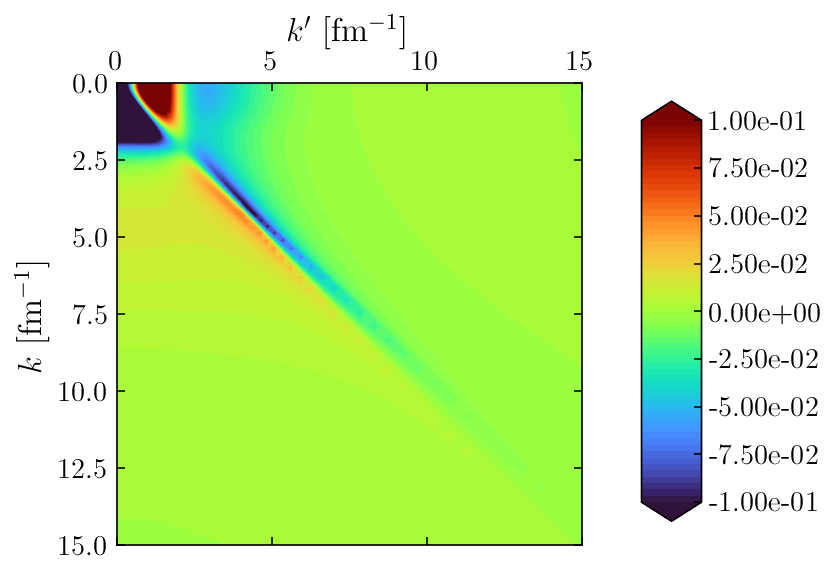

In [34]:
delta_U = unattach_weights_from_matrix(
    k_array, k_weights, delta_U_weights,
    coupled_channel=potential.coupled_channel_bool
)

# \delta U(k, k') in 3S1-3S1 channel
plot_contour(k_array, delta_U[:ntot,:ntot], colorbar_limits=(-0.1,0.1),
             axes_limits=(0.0,15.0))

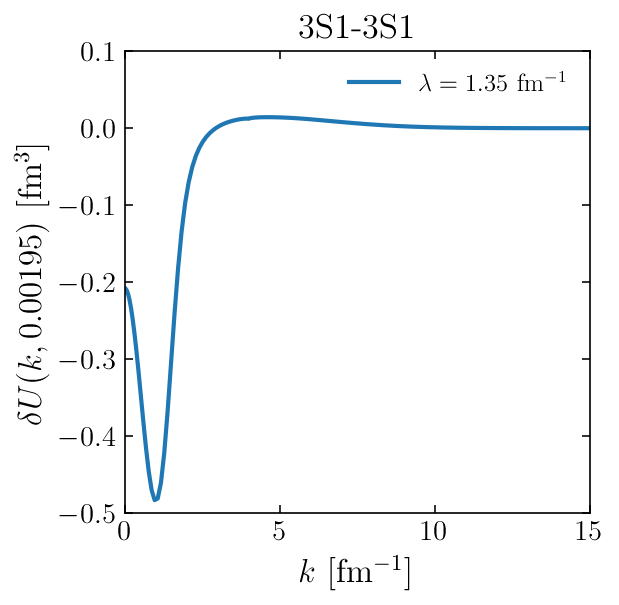

In [35]:
# Off-diagonal slice of \delta U(k, k') in 3S1-3S1 channel
plot_delta_U_slice(k_array, delta_U[:ntot,:ntot], '3S1-3S1', 'Wegner',
                   lambda_array[-1], x_limits=(0.0,15.0), y_limits=(-0.5,0.1))

### Compare to different momentum mesh

In [36]:
# Call Potential
potential_alt = Potential(kvnn, channel, 15.0, 3.0, 120)
k_array_alt, k_weights_alt = potential_alt.load_mesh()

# SRG transformation via solving directly for U(\lambda)
U_matrix_direct_alt = load_srg_transformation(potential_alt, 'Wegner',
                                              lambda_array[-1])

# Get \delta U = U - I
delta_U_weights_alt = get_delta_U(U_matrix_direct_alt)

delta_U_alt = unattach_weights_from_matrix(
    k_array_alt, k_weights_alt, delta_U_weights_alt,
    coupled_channel=potential_alt.coupled_channel_bool
)

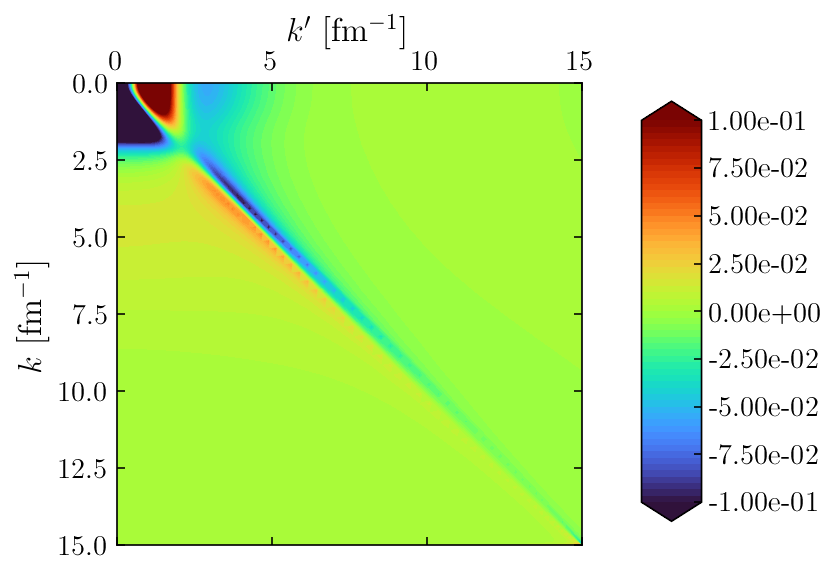

In [37]:
# \delta U(k, k') in 3S1-3S1 channel
plot_contour(k_array_alt, delta_U_alt[:ntot,:ntot], colorbar_limits=(-0.1,0.1),
             axes_limits=(0.0,15.0))

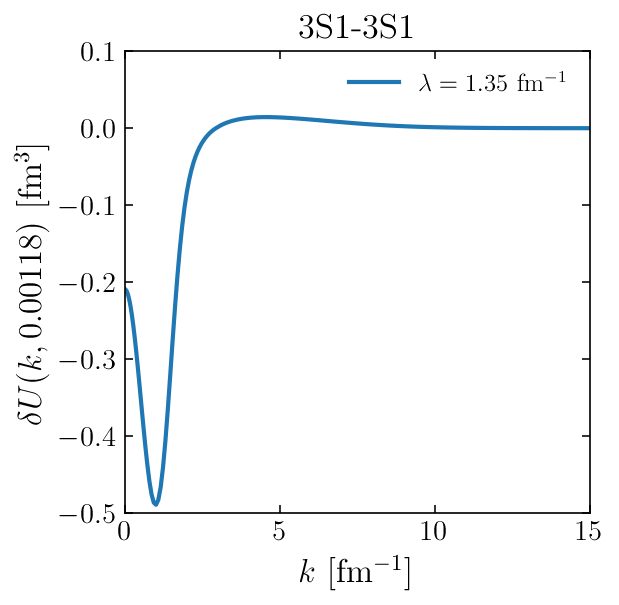

In [38]:
# Off-diagonal slice of \delta U(k, k') in 3S1-3S1 channel
plot_delta_U_slice(k_array_alt, delta_U_alt[:ntot,:ntot], '3S1-3S1', 'Wegner',
                   lambda_array[-1], x_limits=(0.0,15.0), y_limits=(-0.5,0.1))

## Compare interpolating functions of $\delta U$ to its matrix elements

In [39]:
k_fine_array = np.linspace(0, kmax, 1000)
k_grid, kp_grid = np.meshgrid(k_fine_array, k_fine_array, indexing='ij')

In [40]:
# Interpolate \delta U

# Linear order
delta_U_linear_func = RectBivariateSpline(k_array, k_array,
                                          delta_U[:ntot, :ntot], kx=1, ky=1)
delta_U_linear_grid = delta_U_linear_func.ev(k_grid, kp_grid)

# Cubic order
delta_U_cubic_func = RectBivariateSpline(k_array, k_array,
                                         delta_U[:ntot, :ntot], kx=3, ky=3)
delta_U_cubic_grid = delta_U_cubic_func.ev(k_grid, kp_grid)

# Quintic order
delta_U_quintic_func = RectBivariateSpline(k_array, k_array,
                                           delta_U[:ntot, :ntot], kx=5, ky=5)
delta_U_quintic_grid = delta_U_quintic_func.ev(k_grid, kp_grid)

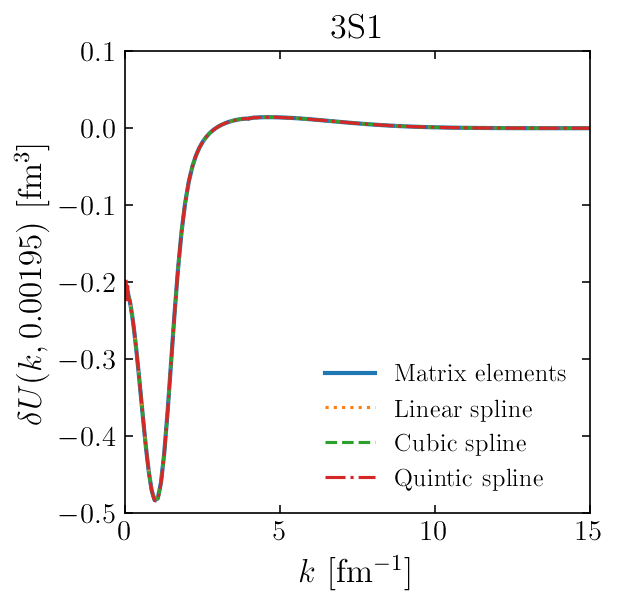

In [41]:
# Compare slices of \delta U interpolations to matrix elements

# --- Figure set-up --- #
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
        
# --- Plot --- #
    
# \lambda label
lambda_label = label_lambda(lambda_array[-1], 'Wegner')
         
# Plot off-diagonal matrix elements
ax.plot(k_array[2:], delta_U[2:ntot,0], label='Matrix elements', linewidth=2.0)
ax.plot(k_fine_array[1:], delta_U_linear_grid[1:,0], label='Linear spline',
        linestyle='dotted')
ax.plot(k_fine_array[1:], delta_U_cubic_grid[1:,0], label='Cubic spline',
        linestyle='dashed')
ax.plot(k_fine_array[1:], delta_U_quintic_grid[1:,0], label='Quintic spline',
        linestyle='dashdot')

# --- Axes limits --- #
ax.set_xlim((0, 15.0))
ax.set_ylim((-0.5, 0.1))
                    
# --- Axes labels --- #
# Label x-axis on bottom row
ax.set_xlabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=16)
                    
# Label y-axis on left column
ax.set_ylabel(rf"$\delta U(k,{k_array[0]:.5f})$ [fm$^3$]", fontsize=16)

# --- Legends --- #
ax.legend(fontsize=12, frameon=False)

# --- Additional labels --- #
# Label partial wave channel
ax.set_title(channel)

plt.show()